# Prediction of the movie revenue

### This dataset *movies.csv* can be downloaded from Google drive: https://drive.google.com/drive/folders/1MwFoUvUp2St0Sjq0I9dlNIl_BXkw3fZU

In [1]:
# import the library
%matplotlib inline

import ast
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

    
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

from sklearn.model_selection import KFold

from sklearn.preprocessing import normalize

from sklearn.model_selection import cross_val_score

# sklearn :: evaluation metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

# apply style to all the charts
sns.set_style('whitegrid')

# convert scientific notation to decimals
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_columns', 24)

# Reading the Data

In [2]:

df = pd.read_csv('data/movies.csv')
df['release_date'] = pd.to_datetime(df['release_date'])
print(df.dtypes)

id                                int64
title                            object
budget                            int64
revenue                         float64
release_date             datetime64[ns]
popularity                      float64
vote_average                    float64
vote_count                      float64
genres                           object
production_companies             object
belongs_to_collection            object
cast                             object
keywords                         object
dtype: object


In [3]:
#Setting cast, production_companies, genres and keywords types to a list of dictionaries

df['genres'] = df['genres'].astype(str)
df['production_companies'] = df['production_companies'].astype(str)
df['cast'] = df['cast'].astype(str)
df['keywords'] = df['keywords'].astype(str)
# df['belongs_to_collection'] = df['belongs_to_collection'].astype(str)

df['genres'] = df['genres'].apply(lambda x: ast.literal_eval(x))
df['production_companies'] = df['production_companies'].apply(lambda x: ast.literal_eval(x))
df['cast'] = df['cast'].apply(lambda x: ast.literal_eval(x))
df['keywords'] = df['keywords'].apply(lambda x: ast.literal_eval(x))
# df['belongs_to_collection'] = df['belongs_to_collection'].apply(lambda x: ast.literal_eval(x))

Some adjustments

In [4]:
#Extra adjustments for the points discovered later during the process

#replace FRF budget by USD
df.loc[df['id'] == 10656, ['budget']] = 25974
print(df.loc[df['id'] == 10656, ['title']])

#wrong revenue
df.loc[df['id'] == 9838, ['revenue']] = 15057465
print(df.loc[df['id'] == 9838, ['title']])

       title
2134  Subway
                     title
1242  King Solomon's Mines


In [5]:
# Analize release date
# We see that there is a strong tendency of grouth movies produced every year
df['year'] = df['release_date'].dt.year
df['year_month'] = pd.to_datetime(df['release_date']).dt.to_period('M')

### Choosing time period

In [6]:
#Slicing our data 

df = df[(df['year']>=2000) & (df['year']<2017)]

print(df.shape)

(3030, 15)


In [7]:
df.head(5)

,id,title,budget,revenue,release_date,popularity,vote_average,vote_count,genres,production_companies,belongs_to_collection,cast,keywords,year,year_month
3,121173,Voracious,11178,34659.00,2012-09-05,0.08,8.00,1.00,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...","[{'name': 'APT Entertainment', 'id': 8355}, {'...",0,"[{'cast_id': 16, 'character': 'Rene', 'credit_...","[{'id': 4694, 'name': 'staged death'}, {'id': ...",2012,2012-09
5,110428,Camille Claudel 1915,3512454,115860.00,2013-03-13,0.11,7.00,20.00,"[{'id': 18, 'name': 'Drama'}]","[{'name': 'Canal+', 'id': 5358}, {'name': 'Art...",0,"[{'cast_id': 3, 'character': 'Camille Claudel'...","[{'id': 254, 'name': 'france'}, {'id': 745, 'n...",2013,2013-03
6,110428,Camille Claudel 1915,3512454,115860.00,2013-03-13,0.11,7.00,20.00,"[{'id': 18, 'name': 'Drama'}]","[{'name': 'Canal+', 'id': 5358}, {'name': 'Art...",0,"[{'cast_id': 3, 'character': 'Camille Claudel'...","[{'id': 254, 'name': 'france'}, {'id': 745, 'n...",2013,2013-03
7,110428,Camille Claudel 1915,3512454,115860.00,2013-03-13,0.11,7.00,20.00,"[{'id': 18, 'name': 'Drama'}]","[{'name': 'Canal+', 'id': 5358}, {'name': 'Art...",0,"[{'cast_id': 3, 'character': 'Camille Claudel'...","[{'id': 254, 'name': 'france'}, {'id': 745, 'n...",2013,2013-03
8,110428,Camille Claudel 1915,3512454,115860.00,2013-03-13,0.11,7.00,20.00,"[{'id': 18, 'name': 'Drama'}]","[{'name': 'Canal+', 'id': 5358}, {'name': 'Art...",0,"[{'cast_id': 3, 'character': 'Camille Claudel'...","[{'id': 254, 'name': 'france'}, {'id': 745, 'n...",2013,2013-03


# Choosing the columns

In [8]:
X = df[['budget', 'year', 'genres', 'production_companies', 'vote_average', 'popularity', 'revenue',  'vote_count', 
        'belongs_to_collection', 'cast']]
# y = df['revenue']
# X = X.reset_index(drop=True)
# y = y.reset_index(drop=True)

# Feature engineering

### Budget

(array([1.977e+03, 5.850e+02, 2.220e+02, 1.450e+02, 5.200e+01, 3.100e+01,
        1.400e+01, 3.000e+00, 0.000e+00, 1.000e+00]),
 array([5.000000e+03, 3.800450e+07, 7.600400e+07, 1.140035e+08,
        1.520030e+08, 1.900025e+08, 2.280020e+08, 2.660015e+08,
        3.040010e+08, 3.420005e+08, 3.800000e+08]),
 <a list of 10 Patch objects>)

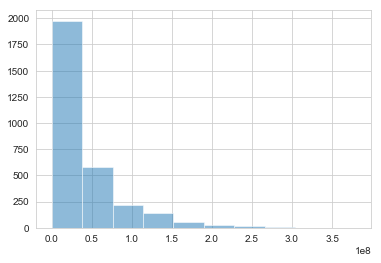

In [9]:
#plt.hist(X['budget'], alpha=0.5)
#print(X.groupby('budget')['id'].count())

#X['budget'] = np.log(X['budget'])
plt.hist(X['budget'], alpha=0.5)

Removing outliers

In [10]:
# print(X['budget'].describe())

# mean_a = np.mean(X['budget'])
# std_a = np.std(X['budget'])

# X = X[(X['budget']>mean_a-3*std_a)&(X['budget']<mean_a+3*std_a)]

# print('After removing outliers:')
# print(X['budget'].describe())

# plt.figure()
# plt.hist(X['budget'])
# plt.show

### Revenue

(array([2.583e+03, 2.670e+02, 8.400e+01, 4.900e+01, 3.100e+01, 1.000e+01,
        3.000e+00, 2.000e+00, 0.000e+00, 1.000e+00]),
 array([1.98000000e+02, 2.06822541e+08, 4.13644883e+08, 6.20467226e+08,
        8.27289568e+08, 1.03411191e+09, 1.24093425e+09, 1.44775660e+09,
        1.65457894e+09, 1.86140128e+09, 2.06822362e+09]),
 <a list of 10 Patch objects>)

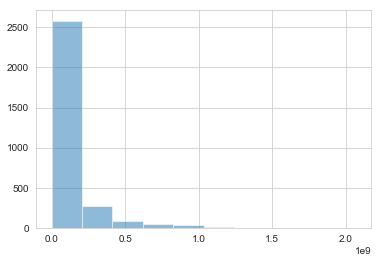

In [11]:
#plt.hist(X['revenue'])

#X['revenue'] = np.log(X['revenue'])
plt.hist(X['revenue'], alpha=0.5)

Removing outliers

In [12]:
# print(X['revenue'].describe())

# mean_a = np.mean(X['revenue'])
# std_a = np.std(X['revenue'])

# X = X[(X['revenue']>mean_a-3*std_a)&(X['revenue']<mean_a+3*std_a)]

# print('After removing outliers:')
# print(X['revenue'].describe())

# plt.figure()
# plt.hist(X['revenue'])
# plt.show

### Vote count

(array([1.172e+03, 5.560e+02, 3.330e+02, 2.160e+02, 1.490e+02, 1.190e+02,
        7.900e+01, 6.200e+01, 6.200e+01, 3.800e+01, 3.800e+01, 3.000e+01,
        2.200e+01, 1.600e+01, 1.900e+01, 1.200e+01, 2.100e+01, 1.300e+01,
        8.000e+00, 7.000e+00, 1.200e+01, 8.000e+00, 4.000e+00, 8.000e+00,
        3.000e+00, 5.000e+00, 2.000e+00, 3.000e+00, 1.000e+00, 2.000e+00,
        0.000e+00, 4.000e+00, 1.000e+00, 0.000e+00, 2.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([1.000000e+00, 2.824800e+02, 5.639600e+02, 8.454400e+02,
        1.126920e+03, 1.408400e+03, 1.689880e+03, 1.971360e+03,
        2.252840e+03, 2.534320e+03, 2.815800e+03, 3.097280e+03,
        3.378760e+03, 3.660240e+03, 3.941720e+03, 4.223200e+03,
        4.504680e+03, 4.786160e+03, 5.067640e+03, 5.349120e+03,
        5.630600e+03, 5.912080e+03, 6.193560e+03, 6.4750

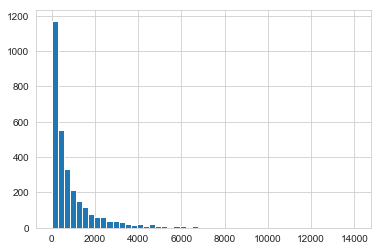

In [13]:
plt.hist(X['vote_count'], bins=50)

### Vote average

(array([  1.,   0.,   0.,   0.,   1.,   2.,   2.,   1.,   0.,   1.,   6.,
          1.,   2.,   6.,   7.,  20.,   5.,  17.,  12.,  18.,  48.,  36.,
         44.,  50., 132.,  72.,  93., 110., 106., 130., 289., 142., 144.,
        128., 286., 151., 148., 120., 100., 190.,  80.,  88.,  57.,  43.,
         70.,  21.,  20.,  16.,   8.,   6.]),
 array([2.3 , 2.42, 2.54, 2.66, 2.78, 2.9 , 3.02, 3.14, 3.26, 3.38, 3.5 ,
        3.62, 3.74, 3.86, 3.98, 4.1 , 4.22, 4.34, 4.46, 4.58, 4.7 , 4.82,
        4.94, 5.06, 5.18, 5.3 , 5.42, 5.54, 5.66, 5.78, 5.9 , 6.02, 6.14,
        6.26, 6.38, 6.5 , 6.62, 6.74, 6.86, 6.98, 7.1 , 7.22, 7.34, 7.46,
        7.58, 7.7 , 7.82, 7.94, 8.06, 8.18, 8.3 ]),
 <a list of 50 Patch objects>)

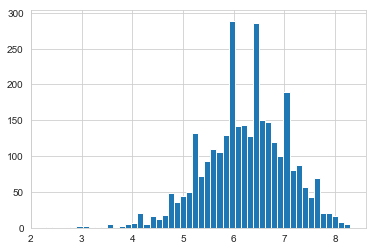

In [14]:
plt.hist(X['vote_average'], bins=50)

Removing outliers

count   3030.00
mean       6.24
std        0.82
min        2.30
25%        5.70
50%        6.30
75%        6.80
max        8.30
Name: vote_average, dtype: float64
After removing outliers:
count   3015.00
mean       6.25
std        0.80
min        3.80
25%        5.70
50%        6.30
75%        6.80
max        8.30
Name: vote_average, dtype: float64


<function matplotlib.pyplot.show(*args, **kw)>

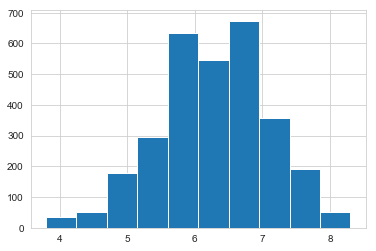

In [15]:
print(X['vote_average'].describe())

mean_a = np.mean(X['vote_average'])
std_a = np.std(X['vote_average'])

X = X[(X['vote_average']>mean_a-3*std_a)&(X['vote_average']<mean_a+3*std_a)]

print('After removing outliers:')
print(X['vote_average'].describe())

plt.figure()
plt.hist(X['vote_average'])
plt.show

### Popularity

(array([ 378., 1247.,  917.,  296.,   87.,   38.,   29.,   12.,    7.,
           4.]),
 array([ 0.079287 ,  4.8040248,  9.5287626, 14.2535004, 18.9782382,
        23.702976 , 28.4277138, 33.1524516, 37.8771894, 42.6019272,
        47.326665 ]),
 <a list of 10 Patch objects>)

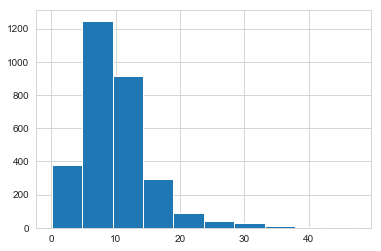

In [16]:
plt.hist(X['popularity'])

Removing outliers

count   3015.00
mean       9.96
std        5.73
min        0.08
25%        6.52
50%        9.12
75%       12.36
max       47.33
Name: popularity, dtype: float64
After removing outliers:
count   2955.00
mean       9.49
std        4.67
min        0.08
25%        6.48
50%        9.00
75%       12.08
max       26.97
Name: popularity, dtype: float64


<function matplotlib.pyplot.show(*args, **kw)>

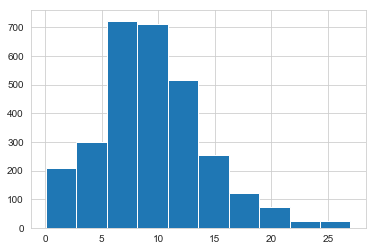

In [17]:

print(X['popularity'].describe())

mean_a = np.mean(X['popularity'])
std_a = np.std(X['popularity'])

X = X[(X['popularity']>mean_a-3*std_a)&(X['popularity']<mean_a+3*std_a)]

print('After removing outliers:')
print(X['popularity'].describe())

plt.figure()
plt.hist(X['popularity'])
plt.show

### Genres

In [18]:
# del X['genres']

In [19]:
index_extractor = lambda df, field, value: [idx for idx, entries in enumerate(df[field]) for item in entries if value in item['name']]
list_creator = lambda df, idx: [1 if i in idx else 0 for i in df.index]

#Extracting list of genres
l=[]
for i, item in enumerate(X['genres']):
    for cell in item:
        l.append(cell['name'])
g_name, g_count = np.unique(np.array(l), return_counts=True)

# Create column for every genre and assigh 1 or 0
for genre in g_name:
    idx = index_extractor(X, 'genres', genre)
    c = list_creator(X, idx)
    genre_col = pd.Series(c)    
    X = X.assign(genre_col=genre_col.values)
    X.rename(columns={'genre_col':'{0}'.format(genre)}, inplace=True)
del X['genres']
  


### Belongs_to_collection

In [20]:
X['collection'] = [0 if col == '0' else 1 for col in X['belongs_to_collection']]
del X['belongs_to_collection']

In [21]:
# index_extractor = lambda df, field, value: [idx for idx, item in enumerate(df[field]) if (type(item) != int) if value in item['name']]
# list_creator = lambda df, idx: [1 if i in idx else 0 for i in df.index]

# #Extracting list of collections
# l=[]
# for i, item in enumerate(X['belongs_to_collection']):
#     if type(item) != int:
#         #print(type(item))
#         #item = ast.literal_eval(item)
#         #print(type(item))
#         l.append(item['name'])
# p_name, p_count = np.unique(np.array(l), return_counts=True)

# prod = zip(p_name, p_count) # list of Unique Values along with occurrence Count
# prod = list(prod)
# prod = sorted(prod, key = lambda x: x[1], reverse = True)
# print('Number of collections: ', len(prod))
    
# #100 collections with the most number of movies in it
# p_name = []
# p_count = []
# for i in range(50):
#     p_name.append(prod[i][0])
#     p_count.append(prod[i][1])

In [22]:
# # Create column for every collection and assigh 1 or 0
# for prod in p_name:
#     idx = index_extractor(X, 'belongs_to_collection', prod)
#     c = list_creator(X, idx)
#     prod_col = pd.Series(c)    
#     X = X.assign(prod_col=prod_col.values)
#     X.rename(columns={'prod_col':'{0}'.format(prod)}, inplace=True)
# del X['belongs_to_collection']

### Production Companies

In [23]:
index_extractor = lambda df, field, value: [idx for idx, entries in enumerate(df[field]) for item in entries if value in item['name']]
list_creator = lambda df, idx: [1 if i in idx else 0 for i in df.index]

#Extracting list of genres
l=[]
for i, item in enumerate(X['production_companies']):
    for cell in item:
        l.append(cell['name'])
p_name, p_count = np.unique(np.array(l), return_counts=True)

prod = zip(p_name, p_count) # list of Unique Values along with occurrence Count
prod = list(prod)
prod = sorted(prod, key = lambda x: x[1], reverse = True)
print('Number of production companies: ', len(prod))
    
#100 companies which produced the hihest number of movies
p_name = []
p_count = []
for i in range(100):
    p_name.append(prod[i][0])
    p_count.append(prod[i][1])

Number of production companies:  3862


In [24]:
# Create column for every production companie and assigh 1 or 0
for prod in p_name:
    idx = index_extractor(X, 'production_companies', prod)
    c = list_creator(X, idx)
    prod_col = pd.Series(c)    
    X = X.assign(prod_col=prod_col.values)
    X.rename(columns={'prod_col':'{0}'.format(prod)}, inplace=True)
del X['production_companies']

### Cast

In [25]:
# del X['cast']

In [26]:

#Extracting list of actors
l=[]
for i, item in enumerate(X['cast']):
    for cell in item:
        l.append(cell['name'])
a_name, a_count = np.unique(np.array(l), return_counts=True)
idx=[]
for i, item  in enumerate(a_name):
    if (item == 'Kar') | (item == 'George') | (a_name[i] == 'Mario') | (a_name[i] == 'Jack') | (a_name[i] == 'Charle') | (a_name[i] == 'Charlie') | (a_name[i] == 'Mars') | (a_name[i] == 'Terry') | (a_name[i] == 'King') | (a_name[i] == 'Sim') | (a_name[i] == 'Elli') | (a_name[i] == 'Carlos') | (a_name[i] == 'Sandra') | (a_name[i] == 'Justin') | (a_name[i] == 'Shane') | (a_name[i] == 'Angela') | (a_name[i] == 'Eve') | (a_name[i] == 'Foster') | (a_name[i] == 'Take') | (a_name[i] == 'Andrea') | (a_name[i] == 'Ade') | (a_name[i] == 'Tiffany') | (a_name[i] == 'Zoë'):
        idx.append(i)
    
a_name = np.delete(a_name, idx)
a_count = np.delete(a_count, idx)

act = zip(a_name, a_count) # list of Unique Values along with occurrence Count
act = list(act)
act = sorted(act, key = lambda x: x[1], reverse = True)
print('Number of actors: ', len(act))

#100 companies which produced the hihest number of movies
a_name = []
a_count = []

for i in range(len(act)):
    if act[i][1] >20:
        a_name.append(act[i][0])
        a_count.append(act[i][1])

        
print(len(a_name), len(a_count))
# plt.figure(figsize=(16,6))
# x_pos = range(len(a_name))
# plt.bar(x_pos,a_count, align='center', alpha=0.5)
# plt.xticks(x_pos, a_name, rotation='vertical')

Number of actors:  39955
108 108


In [27]:
index_extractor = lambda df, field, value: [idx for idx, entries in enumerate(df[field]) for item in entries if value in item['name']]
list_creator = lambda df, idx: [1 if i in idx else 0 for i in df.index]
# Create column for every actor and assigh 1 or 0
for actor in a_name:
    idx = index_extractor(X, 'cast', actor)
    c = list_creator(X, idx)
    prod_col = pd.Series(c)    
    X = X.assign(prod_col=prod_col.values)
    X.rename(columns={'prod_col':'{0}'.format(actor)}, inplace=True)
del X['cast']

In [28]:
X.head(5)

,budget,year,vote_average,popularity,revenue,vote_count,Action,Adventure,Animation,Comedy,Crime,Documentary,...,Kevin Hart,Luis Guzmán,Maggie Gyllenhaal,Michael Gambon,Michael Peña,Peter Sarsgaard,Rosario Dawson,Ryan Reynolds,Simon Pegg,Susan Sarandon,Terrence Howard,Tom Hanks
3,11178,2012,8.00,0.08,34659.00,1.00,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0
5,3512454,2013,7.00,0.11,115860.00,20.00,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0
6,3512454,2013,7.00,0.11,115860.00,20.00,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0
7,3512454,2013,7.00,0.11,115860.00,20.00,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0
8,3512454,2013,7.00,0.11,115860.00,20.00,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0


# Saving to the file

In [38]:
X.head(5)
X.to_csv('data/X_15.csv', index=False)

# Prediction

In [29]:
y = X['revenue']
del X['revenue']
#del X['year']

#X = pd.DataFrame(normalize(X, axis=0))

X = X.reset_index(drop=True)
y = y.reset_index(drop=True)
X.head(5)

,budget,year,vote_average,popularity,vote_count,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,...,Kevin Hart,Luis Guzmán,Maggie Gyllenhaal,Michael Gambon,Michael Peña,Peter Sarsgaard,Rosario Dawson,Ryan Reynolds,Simon Pegg,Susan Sarandon,Terrence Howard,Tom Hanks
0,11178,2012,8.00,0.08,1.00,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0
1,3512454,2013,7.00,0.11,20.00,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0
2,3512454,2013,7.00,0.11,20.00,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0
3,3512454,2013,7.00,0.11,20.00,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0
4,3512454,2013,7.00,0.11,20.00,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0


In [30]:
scores = cross_val_score(RandomForestRegressor(500), X, y, cv=10)
print('cross_val_score', np.mean(scores))

cross_val_score 0.6160989012807915


### Grid Search

In [31]:
# from sklearn.model_selection import GridSearchCV
# # Create the parameter grid based on the results of random search 
# param_grid = {
# #    'bootstrap': [True],
# #    'max_depth': [80, 90, 100, 110],
# #    'max_features': [2, 3],
# #    'min_samples_leaf': [3, 4, 5],
# #    'min_samples_split': [8, 10, 12],
#     'n_estimators': [100, 200, 300, 500, 1000]
# }
# # Create a based model
# rf = RandomForestRegressor()
# grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)
# grid_search.fit(X, y)
# print(grid_search.best_params_)
# print(grid_search.best_score_)
# print(grid_search.best_estimator_)

MODEL RandomForestRegressor


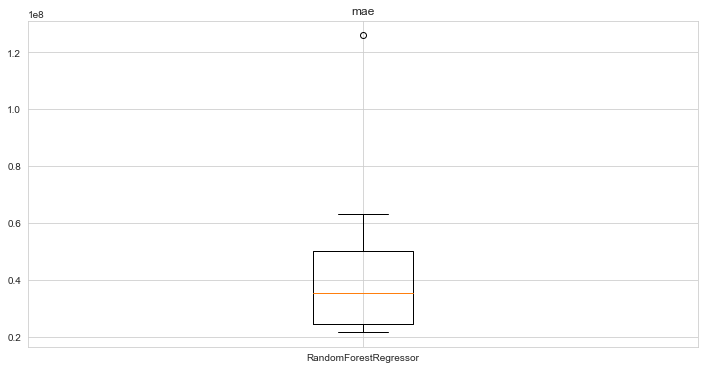

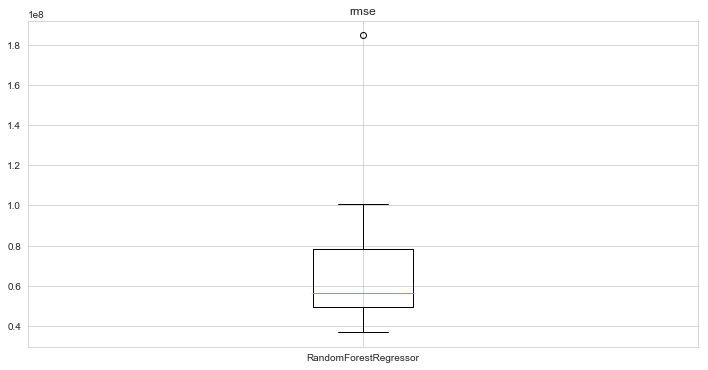

In [32]:
models = [ ('RandomForestRegressor', RandomForestRegressor(n_estimators=300, n_jobs=-1)),
           # ('Ridge Regressor', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None, normalize=False, random_state=None, solver='auto', tol=0.001))
]
#('GradientBoosting', GradientBoostingRegressor()),
#('LinearRegression', LinearRegression()),
#('LassoRegressor', Lasso(alpha=0.1)),
#('RandomForestRegressor10', RandomForestRegressor(n_estimators=10)),
#('DecisionTreeRegressor', DecisionTreeRegressor())
#('KNeighborsRegressor', KNeighborsRegressor(5))

#('SVMRegressor', SVR()), - Slow - check the optimal C (find the function)
#('GaussianRegressor',GaussianProcessRegressor()),
#('SGDRegressor', SGDRegressor(), - bad results, check the parameters

k = 10
results = {}
for m in models:
    print('MODEL', m[0])
    results[m[0]] = {'mae':[], 'rmse':[]}
    kf = KFold(n_splits=k)
    for train_index, test_index in kf.split(X):
        X_train_k, X_test_k = X.values[train_index], X.values[test_index]
        y_train_k, y_test_k = y.values[train_index], y.values[test_index]
        model = m[1]
        model.fit(X_train_k, y_train_k.ravel())
        y_pred = model.predict(X_test_k)
        mae = mean_absolute_error(y_test_k, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test_k, y_pred))
        results[m[0]]['mae'].append(mae)
        results[m[0]]['rmse'].append(rmse)
        
for metric in ['mae', 'rmse']:
    values = []
    labels = []
    for model, result_values in results.items():
        for m, v in result_values.items():
            if m == metric:
                labels.append(model)
                values.append(v)
    plt.figure(figsize=(12,6))
    plt.title(metric)
    plt.boxplot(values)
    plt.xticks(range(1, len(labels)+1), labels, rotation='horizontal')
    plt.show()

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
print('X_train: ', X_train.shape, 'y_train:', y_train.shape, '\nX_test: ', X_test.shape, 'y_test: ', y_test.shape)
#print(X_train.head(5))
#model = LinearRegression()
model = RandomForestRegressor(500)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

X_train:  (1979, 233) y_train: (1979,) 
X_test:  (976, 233) y_test:  (976,)


MAE 43359797.44842828


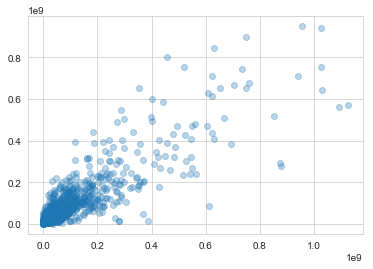

In [34]:
# Evaluate the model using the Mean Absolute Error
from sklearn.metrics import mean_absolute_error
print('MAE', mean_absolute_error(y_test, y_pred))

# plot the results
plt.scatter(y_test, y_pred, alpha=0.3)
plt.show()

### Feature Importances

In [35]:
print(model)
fi = []
for i, col in enumerate(X_test.columns):
    fi.append([col, model.feature_importances_[i]])
features = pd.DataFrame(fi).sort_values(1, ascending=False)
print(type(features))
print(features)
useless = list(features.loc[features[1] < 0.0003, 0])
print(useless)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
<class 'pandas.core.frame.DataFrame'>
                              0    1
0                        budget 0.54
4                    vote_count 0.29
3                    popularity 0.06
2                  vote_average 0.04
1                          year 0.03
24                   collection 0.02
20              Science Fiction 0.00
75           Nickelodeon Movies 0.00
108              Platinum Dunes 0.00
11                        Drama 0.00
21                     Thriller 0.00
8                        Comedy 0.00
198                Stephen Root 0.00
5                        Action 0.00
74        Blumhouse 

### Error Analysis

In [36]:
df_new = pd.DataFrame(X_test).copy()
print(df_new.count())
print(len(y_pred))
df_new['revenue'] = y_test
df_new['prediction'] = y_pred
df_new['abs_error'] = abs(df_new['revenue']-df_new['prediction'])
df_new.sort_values(by='abs_error', ascending=False).round()
print(df_new.head())

budget                                    976
year                                      976
vote_average                              976
popularity                                976
vote_count                                976
Action                                    976
Adventure                                 976
Animation                                 976
Comedy                                    976
Crime                                     976
Documentary                               976
Drama                                     976
Family                                    976
Fantasy                                   976
Foreign                                   976
History                                   976
Horror                                    976
Music                                     976
Mystery                                   976
Romance                                   976
Science Fiction                           976
Thriller                          

In [37]:
df_error = df_new[df_new['abs_error']>1]
#df_error.groupby()
df_error.corr()['abs_error'].dropna().sort_values()

Drama                                    -0.18
Comedy                                   -0.12
Romance                                  -0.12
Thriller                                 -0.10
Crime                                    -0.07
Adventure                                -0.06
Mystery                                  -0.06
Action                                   -0.06
Twentieth Century Fox Film Corporation   -0.05
Dune Entertainment                       -0.05
Warner Bros.                             -0.05
Horror                                   -0.05
Epsilon Motion Pictures                  -0.05
New Line Cinema                          -0.05
Universal Pictures                       -0.04
Western                                  -0.04
Metro-Goldwyn-Mayer (MGM)                -0.04
Science Fiction                          -0.04
Cate Blanchett                           -0.04
David Koechner                           -0.04
Documentary                              -0.04
Morgan Freema